In [371]:
import json
import new_env
import copy
import numpy as np

In [372]:
import networkx as nx
import matplotlib.pyplot as plt

In [373]:
with open("dataset.json") as fp:
    dataset = json.load(fp)


env = new_env.HolEnv("T")
paper_goals = []
for goal in dataset:
    try:
        p_goal = env.get_polish(goal)
        paper_goals.append((p_goal[0]["polished"]['goal'], goal))
    except:
        print (goal)

Importing theories...
Loading modules...
Configuration done.
DATATYPE ((sum :(α -> α + β) -> (β -> α + β) -> γ) (INL :α -> α + β) (INR :β -> α + β))
∀(A :α -> bool) (B :β -> bool) (C :α -> bool) (D :β -> bool). A × B ∩ (C × D) = A ∩ C × (B ∩ D)
DATATYPE ((list :α list -> (α -> α list -> α list) -> bool) ([] :α list) (CONS :α -> α list -> α list))


In [376]:
polished = [i for i in map(lambda x: x[0], paper_goals)]

In [377]:
print (polished[0])

@ C$bool$ ! | Vs1 @ C$bool$ ! | Vs2 @ @ C$min$ = @ @ C$pred_set$ PSUBSET Vs1 Vs2 @ @ C$bool$ /\ @ @ C$pred_set$ SUBSET Vs1 Vs2 @ C$bool$ ~ @ @ C$pred_set$ SUBSET Vs2 Vs1


In [378]:
class AST:
    def __init__(self, node, children=[], parent=None):
        self.node = node
        self.children = children
        self.parent = [parent]
    def _print(self, depth=1):
        print (depth * "--- " + self.node.value)
        if len(self.children) > 0:
            for child in self.children:
                child._print(depth+1)
        
class Token:
    def __init__(self, value, _type, arity=None):
        self.value = value
        self._type = _type
        self.arity = arity
    
#assume ast has been passed with ast.node as function 
def func_to_ast(ast, tokens, arity):
    if len(tokens) == 0:
        return ast

    node = tokens[0]
    tokens.pop(0)

    new_node = AST(node, children = [], parent=ast)
    
    if node._type == "variable":

        ast.children.append(new_node)

    elif node._type == "func" or node._type == "quantifier":

        new_ast = func_to_ast(new_node, tokens, node.arity)
        ast.children.append(new_ast)
      
        
    if arity == 1:
        return ast
    else:
        return func_to_ast(ast, tokens, arity-1)
    
def tokens_to_ast(tokens):
    ast = AST(tokens[0], children=[])
    tokens.pop(0)
    return func_to_ast(ast, tokens, ast.node.arity)


In [499]:
def polished_to_tokens_2(goal):
    polished_goal = goal.split(" ")
    tokens = []
    
    while len(polished_goal) > 0:
        if polished_goal[0] == '@':
            polished_goal.pop(0)
            arity = 1
            
            while polished_goal[0] == '@':
                arity += 1
                polished_goal.pop(0)
                
            func = polished_goal[0]
            polished_goal.pop(0)
            
            #quantifiers should be considered with arity 2 for constructing the tree (for now?)?
            if func == 'C$bool$' and (polished_goal[0] == '!' or polished_goal[0] == '?'):
                    #arity = 2
                    #as there's 2 space separated characters for quantifiers
                    func = func + "|" + polished_goal[0] #+ polished_goal[1]
                    polished_goal.pop(0)
                    tokens.append(Token(func, "quantifier", arity))

                    
            else:
                if func[0] == 'C':
                    #should only be one string after the library 
                    func = func + "|" + polished_goal[0]
                    polished_goal.pop(0)
            #otherwise variable func, and nothing following it
                
                tokens.append(Token(func, "func", arity))
        
        #variable or constant case
        else:
            var = polished_goal[0]
            polished_goal.pop(0)
            #lambda case
            if var[0] == "|":
                tokens.append(Token("".join(var), "func", 2))
            else:
            
                if var[0] == "C":
                    #need to append this and the next as constants are space separated
                    var = var + polished_goal[0]
                    polished_goal.pop(0)

                tokens.append(Token("".join(var), "variable"))

    return tokens
            

In [500]:
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

In [675]:
def print_graph(ast):
    G = nx.DiGraph()
    add_node(ast, G)
    
    labels = nx.get_node_attributes(G, 'value')
    pos = hierarchy_pos(G,ast.node)    
    plt.figure(1,figsize=(15,30)) 
    nx.draw(G, pos=pos, labels=labels, with_labels=True,
            arrowsize=20,
            node_color='none',
            node_size=6000)#, font_weight='bold')
    
    
    labels = {e: G.get_edge_data(e[0], e[1])["child"] for e in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    ax = plt.gca() # to get the current axis
    ax.collections[0].set_edgecolor("#FF0000") 
    plt.savefig("Graph.png", format="PNG")
    #plt.show()
# 0

def add_node(ast, graph):
    graph.add_node(ast.node, value = str(ast.node.value))
    for i, child in enumerate(ast.children):
        graph.add_edge(ast.node, child.node, child=i)
        add_node(child, graph)
    
#verticalalignment='bottom'

In [676]:
def add_quantified_children(quantifier_ast):
    #child should be '|' with first child of that as variable, and rest as quantified scope
    var = quantifier_ast.children[0].children[0].node.value
    sub_tree = quantifier_ast.children[0].children[1]
    
    def apply_quantifier(ast, var):
        if ast.node.value == var:
            quantifier_ast.children[0].children.append(ast)
            ast.parent.append(quantifier_ast.children[0])
            for child in ast.children:
                apply_quantifier(child,var) 
        else:
            for child in ast.children:
                apply_quantifier(child,var)
        return
    
    apply_quantifier(sub_tree, var)
    return quantifier_ast
    

def process_quantifiers(ast):
    if ast.node._type == 'quantifier':
        add_quantified_children(ast)
        for child in ast.children:
            process_quantifiers(child)
    else:
        for child in ast.children:
            process_quantifiers(child)
    return ast


In [677]:
def merge_leaves(ast):
    leaves = []

    def get_leaves(ast):
        if ast.children == []:
            leaves.append(ast)
        else:
            for child in ast.children:
                get_leaves(child)
        return
    
    get_leaves(ast)
    
    leaf_tokens = set(leaves)
    leaf_values = set([x.node.value for x in leaves])
    
    q_tokens = []
    #only merge leaf nodes if they're within the same quantified scope
    
    #run for all quantifiers (process_quantifiers but with get leaves as inner function)
    def run_quantifiers(quantifier_ast):
        var = quantifier_ast.children[0].children[0].node.value
        sub_tree = quantifier_ast.children[0].children[1]
        quantified_token = quantifier_ast.children[0].children[0]
        q_tokens.append(quantified_token)
        
        def merge_quantifier(ast, var):
            #if quantified variable, and leaf node, point parents to original node
            if ast.node.value == var and ast.children == []:
                #this way ensures no duplicates 
                for parent in ast.parent:
                    new_children = []
                    flag = False
                    for c in parent.children:
                        if c.node.value != var or c.children != []:
                            new_children.append(c)
                        elif flag == False:
                            new_children.append(quantified_token)
                            flag = True
                    parent.children = new_children
                
            for child in ast.children:
                merge_quantifier(child,var) 

            return ast 

        merge_quantifier(sub_tree, var)
        return quantifier_ast
    
    def merge_all_quantifiers(ast):
        if ast.node._type == 'quantifier':
            run_quantifiers(ast)
            for child in ast.children:
                merge_all_quantifiers(child)
        else:
            for child in ast.children:
                merge_all_quantifiers(child)
        return ast    
    
    merge_all_quantifiers(ast)
    
    #TODO no quantifier case
    print (set(q_tokens) - leaf_tokens)
    
    
#     for value in leaf_values:
#         tokens = [token for token in leaf_tokens if token.node.value == value]
#         parents = []
#         #take first token as one for all to point to
#         new_token = tokens[0]
        
#         for token in tokens[1:]:
#             for parent in token.parent:
#                 new_children = []
#                 flag = False
#                 for c in parent.children:
#                     if c.node.value != value or c.children != []:
#                         new_children.append(c)
#                     elif flag == False:
#                         new_children.append(new_token)
#                         flag = True
#                 parent.children = new_children

                
    return ast
        
    

In [678]:
def rename(ast):
    if ast.node.value[0] == 'V':
        if ast.children != []:
            ast.node.value = "VARFUNC"
        else:
            ast.node.value = "VAR"

    for child in ast.children:
        rename(child)
    
    return ast


In [679]:
def goal_to_graph(polished_goal):
    return rename(merge_leaves(process_quantifiers(tokens_to_ast(polished_to_tokens_2(polished_goal)))))

In [680]:
#get all unique tokens from database 

with open("new_db.json") as fp:
    db = json.load(fp)
    

polished_goals = []
for val in db.values():
    polished_goals.append(val[2])

tokens = list(set([token.value for polished_goal in polished_goals for token in polished_to_tokens_2(polished_goal)  if token.value[0] != 'V']))

tokens.append("VAR")
tokens.append("VARFUNC")
tokens.append("UNKNOWN")

#print (len(tokens))

set()


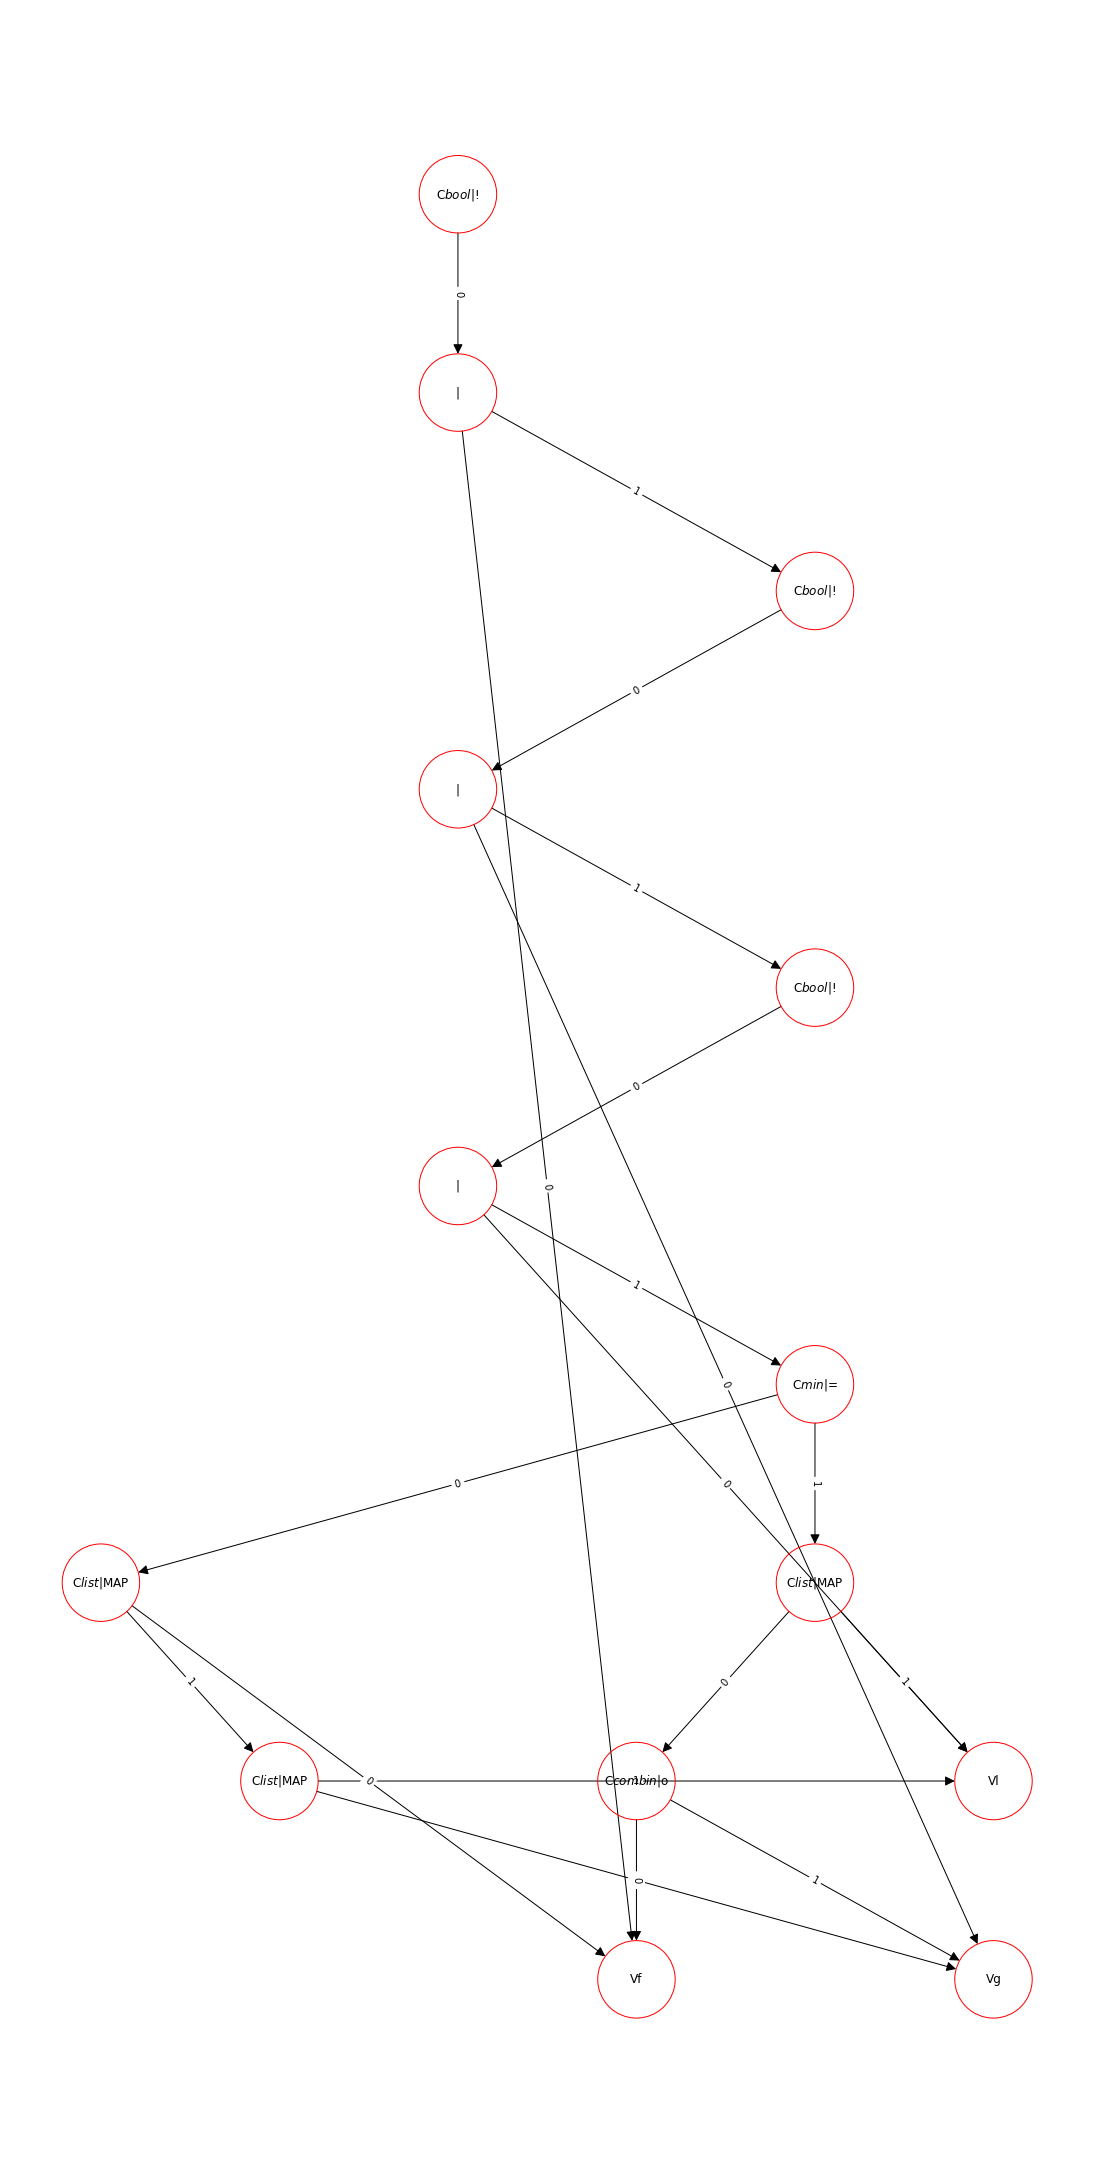

In [712]:
print_graph(merge_leaves(process_quantifiers(tokens_to_ast(polished_to_tokens_2(polished[2])))))

set()


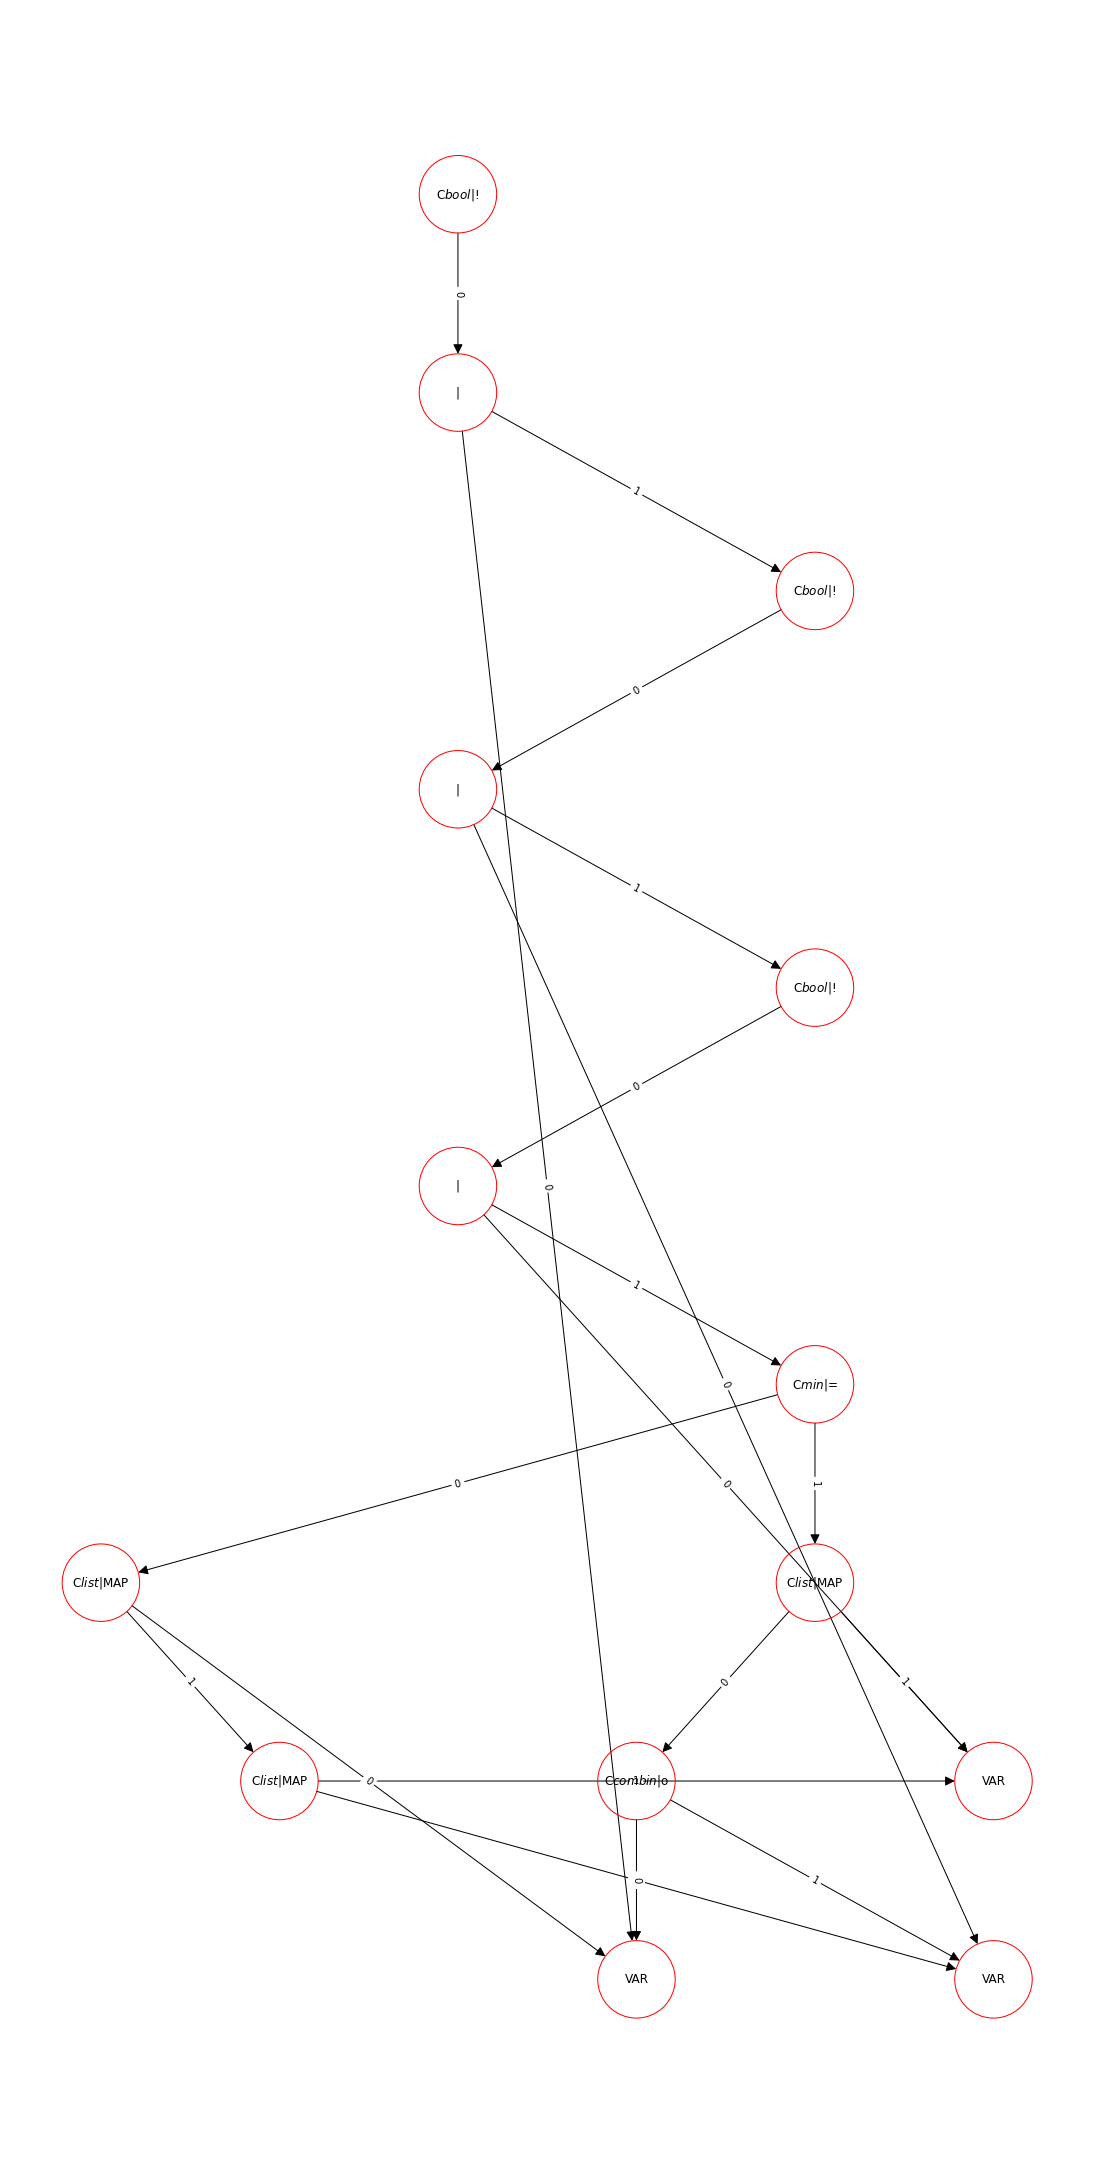

In [713]:
print_graph(goal_to_graph(polished[2]))

In [681]:
# graphs = (goal_to_graph(g) for g in polished_goals)

# for goal in polished_goals:
#     print (goal)
#     print_graph(goal_to_graph(goal))

In [682]:
#TODO deal with | with e.g. @ C$bool$ ! | Vp @ C$bool$ ! | VE @ @ C$min$ = @ @ C$probability$ tail_algebra Vp VE @ @ C$pair$ , @ C$probability$ p_space Vp @ C$pred_set$ BIGINTER @ @ C$pred_set$ IMAGE | Vn @ C$sigma_algebra$ subsets @ @ C$sigma_algebra$ sigma @ C$probability$ p_space Vp @ @ C$pred_set$ IMAGE VE @ C$iterate$ from Vn C$pred_set$ UNIV

In [683]:
#print_graph(goal_to_graph(polished[]))

In [684]:
# i = 1200


# #create tokens from polished goal
# x = polished_to_tokens_2(polished[i])

# #create ast from polished tokens
# test = tokens_to_ast(x)

# #test2 = copy.deepcopy(test)

# #add edges from quantifiers to all variables
# process_quantifiers(test2)

# #test3 = copy.deepcopy(test2)

# #merge leaf nodes into single variable
# merge_leaves(test3)

# #test4 = copy.deepcopy(test3)

# #rename variables and variable functions
# rename(test4)


# print (paper_goals[i])
# #print_graph(test)
# #print_graph(test2)
# print_graph(test3)
# print_graph(test4)

In [685]:
# x = Token("x", "func", 2)
# plus = Token("+", "func", 2)
# neg = Token("-", "func", 1)
# two = Token("2", "variable")
# five = Token("5", "variable")
# seven = Token("7", "variable")
# f = Token("f", "func", 3)
# tokens = [x, neg, two, plus, five, f, two, five, seven]

# ast_ = AST(x)

# tokens.pop(0)

# new_ast = func_to_ast(ast_, tokens, 2)

In [686]:
#token_list = list(map(lambda xs: [x.value for x in xs], [polished_to_tokens_2(goal) for goal in polished]))

In [687]:
#all lambda expressions
#list(map(lambda x: x if '|' in x[1] else None, [(i, x) for i,x in enumerate(token_list)]))
    

[(0,
  ['C$bool$|!',
   '|',
   'Vs1',
   'C$bool$|!',
   '|',
   'Vs2',
   'C$min$|=',
   'C$pred_set$|PSUBSET',
   'Vs1',
   'Vs2',
   'C$bool$|/\\',
   'C$pred_set$|SUBSET',
   'Vs1',
   'Vs2',
   'C$bool$|~',
   'C$pred_set$|SUBSET',
   'Vs2',
   'Vs1']),
 (1,
  ['C$bool$|!',
   '|',
   'Vp',
   'C$min$|=',
   'C$bool$|?',
   '|',
   'Vn',
   'Vp',
   'Vn',
   'C$bool$|/\\',
   'Vp',
   'C$while$|LEAST',
   'Vp',
   'C$bool$|!',
   '|',
   'Vn',
   'C$min$|==>',
   'C$prim_rec$|<',
   'Vn',
   'C$while$|LEAST',
   'Vp',
   'C$bool$|~',
   'Vp',
   'Vn']),
 (2,
  ['C$bool$|!',
   '|',
   'Vf',
   'C$bool$|!',
   '|',
   'Vg',
   'C$bool$|!',
   '|',
   'Vl',
   'C$min$|=',
   'C$list$|MAP',
   'Vf',
   'C$list$|MAP',
   'Vg',
   'Vl',
   'C$list$|MAP',
   'C$combin$|o',
   'Vf',
   'Vg',
   'Vl']),
 None,
 None,
 (5,
  ['C$bool$|!',
   '|',
   'VP',
   'C$min$|==>',
   'C$bool$|/\\',
   'C$bool$|!',
   '|',
   'Va',
   'VP',
   'C$option$|SOME',
   'Va',
   'VP',
   'C$option$NONE',